## Forecast Models

### Imports

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import dates
import mplfinance as mpf
%matplotlib inline
import statsmodels.api as sm
import seaborn as sns

import chart_studio.plotly as py
import plotly.express as px
import plotly.graph_objects as go

import cufflinks as cf # Connects Plotly to Pandas
# Makes Plotly work in your Notebook
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()

import requests # Get URL data
from bs4 import BeautifulSoup # Manipulate URL data
import json
from pandas import DataFrame as df

### Analyzing Time Series

The Granger Causality test tells us if 1 time series can help us forecast the results in another. 

In [24]:
from statsmodels.tsa.stattools import grangercausalitytests

def plot_health_data(ax, csv, country, col, mult):
    cal_df = pd.read_csv(csv)
    indexer = cal_df[cal_df['location']==country].index
    country_df = cal_df.loc[indexer, 'date':col]
    country_df = country_df.dropna()
    country_df.set_index('date', inplace=True)
    country_df.drop(country_df.columns.difference([col]), axis=1, inplace=True)
    country_df[col] = country_df[col] * mult
    ax = country_df.plot(ax=ax)

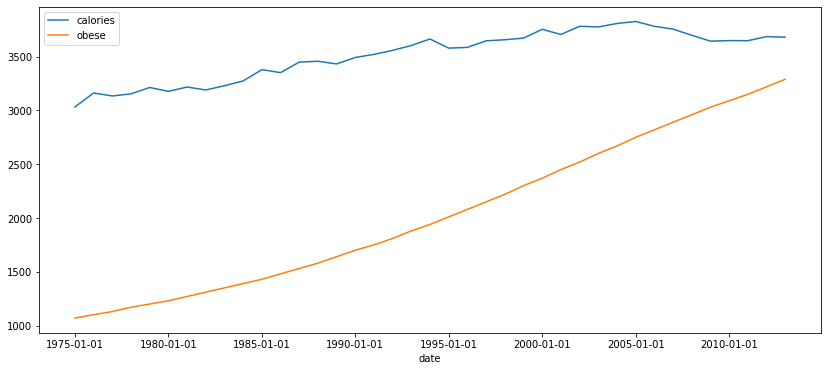

In [25]:
fig, ax = plt.subplots(figsize=(14,6))
plot_health_data(ax, 'US-Daily-Calories.csv', 'United States',
                'calories', 1)
plot_health_data(ax, 'US-Obese.csv', 'United States',
                'obese', 100)

In [27]:
cal_df = pd.read_csv('US-Daily-Calories.csv')
obese_df = pd.read_csv('US-Obese.csv')
new_df = pd.concat([cal_df, obese_df.obese], axis=1)
new_df

,date,location,calories,obese
0,1975-01-01,United States,3033,10.7
1,1976-01-01,United States,3163,11.0
2,1977-01-01,United States,3135,11.3
3,1978-01-01,United States,3155,11.7
4,1979-01-01,United States,3214,12.0
5,1980-01-01,United States,3178,12.3
6,1981-01-01,United States,3218,12.7
7,1982-01-01,United States,3191,13.1
8,1983-01-01,United States,3230,13.5
9,1984-01-01,United States,3275,13.9


In [29]:
obese_diff = np.diff(new_df['obese'], n=1, axis=-1)
obese_diff

array([0.3, 0.3, 0.4, 0.3, 0.3, 0.4, 0.4, 0.4, 0.4, 0.4, 0.5, 0.5, 0.5,
       0.6, 0.6, 0.5, 0.6, 0.7, 0.6, 0.7, 0.7, 0.7, 0.7, 0.8, 0.7, 0.8,
       0.7, 0.8, 0.7, 0.8, 0.7, 0.7, 0.7, 0.7, 0.6, 0.6, 0.7, 0.7])

In [30]:
cal_diff = np.diff(new_df['calories'], n=1, axis=-1)
new_df = pd.concat([cal_df, pd.Series(obese_diff).rename('ObeseDiff')],
                  axis=1)
new_df = pd.concat([new_df, pd.Series(cal_diff).rename('CalDiff')],
                  axis=1)
new_df = new_df.dropna()
new_df

,date,location,calories,ObeseDiff,CalDiff
0,1975-01-01,United States,3033,0.3,130.0
1,1976-01-01,United States,3163,0.3,-28.0
2,1977-01-01,United States,3135,0.4,20.0
3,1978-01-01,United States,3155,0.3,59.0
4,1979-01-01,United States,3214,0.3,-36.0
5,1980-01-01,United States,3178,0.4,40.0
6,1981-01-01,United States,3218,0.4,-27.0
7,1982-01-01,United States,3191,0.4,39.0
8,1983-01-01,United States,3230,0.4,45.0
9,1984-01-01,United States,3275,0.4,105.0


In [31]:
grangercausalitytests(new_df[['ObeseDiff', 'CalDiff']], maxlag=4)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4824  , p=0.4921  , df_denom=34, df_num=1
ssr based chi2 test:   chi2=0.5249  , p=0.4687  , df=1
likelihood ratio test: chi2=0.5212  , p=0.4703  , df=1
parameter F test:         F=0.4824  , p=0.4921  , df_denom=34, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.5387  , p=0.0953  , df_denom=31, df_num=2
ssr based chi2 test:   chi2=5.8964  , p=0.0524  , df=2
likelihood ratio test: chi2=5.4605  , p=0.0652  , df=2
parameter F test:         F=2.5387  , p=0.0953  , df_denom=31, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.1821  , p=0.0392  , df_denom=28, df_num=3
ssr based chi2 test:   chi2=11.9329 , p=0.0076  , df=3
likelihood ratio test: chi2=10.2680 , p=0.0164  , df=3
parameter F test:         F=3.1821  , p=0.0392  , df_denom=28, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.9832  , p=0.0043  , df_d

{1: ({'ssr_ftest': (0.4823702925928692, 0.4920696533817337, 34.0, 1),
   'ssr_chi2test': (0.5249323772334165, 0.4687452204257785, 1),
   'lrtest': (0.5212435236474846, 0.4703117117448017, 1),
   'params_ftest': (0.48237029258426395, 0.49206965338556774, 34.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (2.5387421611472734, 0.09526742606059543, 31.0, 2),
   'ssr_chi2test': (5.896433406535602, 0.052433126448493156, 2),
   'lrtest': (5.460543478315458, 0.06520156944103427, 2),
   'params_ftest': (2.5387421611475927, 0.0952674260605693, 31.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (3.182098633453852, 0.03921153941085653, 28.0, 3),
   'ssr_chi2test': (11.932869875451944, 0.00761669359057782, 3),
   'lrtest': (10.267957654669715, 0.016420488807945922, 3),
   'params_ftest': (3.1820986334537777, 0.039211539410859524, 28.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0

### MeanABS MSE, and RMSE

Mean Absolute Error : Difference between Prediction and Result and find Average

Mean Squared Error : Takes the difference to Find Mean, but Errors Show Dramatically

Root Mean Squared Error : Finding the Square Root Returns to the Original Unit

In [61]:
covid_df.stats

AttributeError: 'DataFrame' object has no attribute 'stats'

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 250 entries, 2020-03-01 to 2020-11-05
Freq: D
Data columns (total 1 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   new_deaths_per_million  0 non-null      float64
dtypes: float64(1)
memory usage: 3.9 KB


/tmp/ipykernel_730/2849884366.py:21: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only

/home/zanflyheit/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/statsmodels/tsa/exponential_smoothing/initialization.py:95: RuntimeWarning:

Mean of empty slice



ValueError: shapes (2,10) and (0,1) not aligned: 10 (dim 1) != 0 (dim 0)

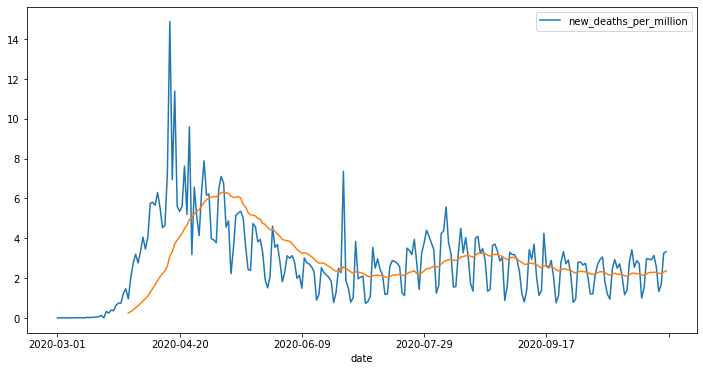

In [53]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tools.eval_measures import mse, rmse, meanabs

# Import Our World in Data CSV
# https://github.com/owid/covid-19-data/tree/master/public/data
owid_df = pd.read_csv('owid-covid-data-11-5.csv')

owid_df.columns # Show all columns

# Create Numpy array of unique countries
covid_df = owid_df.location.unique()
# Get indexes for United States
indexer = owid_df[owid_df['location']=='United States'].index
# Get dataframe location and column data for country name
covid_df = owid_df.loc[indexer, 'date':'new_deaths_per_million']
# Delete NaN values
covid_df = covid_df.dropna()
# Set date as index
covid_df.set_index('date', inplace=True)
# Remove all columns except for what I want
covid_df.drop(covid_df.columns.difference(['new_deaths_per_million']), 1, inplace=True)
covid_df.plot(figsize=(12,6))
# Plot a 30 day moving average
covid_df.rolling(window=30).mean()['new_deaths_per_million'].plot()

covid_df = covid_df.asfreq('d') # Set frequency for daily
# covid_df = covid_df.set_index('date').asfreq('d')
# Get the number of data points we have
covid_df.info() # 241 : 192 Training : 49 Test
# Separate into 2 pieces
train_df = covid_df.iloc[:192]
test_df = covid_df.iloc[191:]

# There is no exponential growth so I'll use additive
# I picked 14 for period because it provided the best result
fit_model = ExponentialSmoothing(train_df['new_deaths_per_million'],
                                  trend='add',
                                  seasonal='add',
                                  seasonal_periods=14).fit()
# We can now make predictions 50 days into the future
prediction = fit_model.forecast(50)
prediction

# Plot training, testing and projection data
train_df['new_deaths_per_million'].plot(figsize=(12,6))
test_df['new_deaths_per_million'].plot()
prediction.plot(xlim=['2020-09-09','2020-11-05'])

rmse(test_df, prediction, axis=None)


### Testing for Seasonality

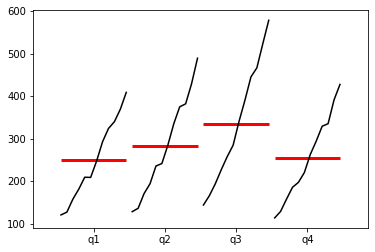

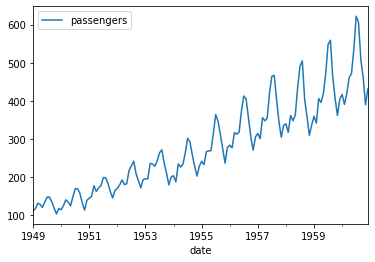

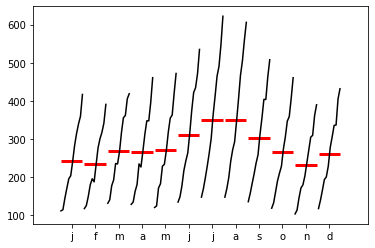

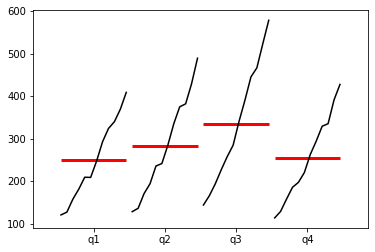

In [18]:
from statsmodels.graphics.tsaplots import month_plot, quarter_plot

flight_df = sns.load_dataset('flights')
flight_df['day'] = '01'
flight_df['month'] = pd.to_datetime(flight_df.month, format='%B').dt.month
flight_df['date'] = pd.to_datetime(flight_df[['year', 'month', 'day']])
flight_df.drop('year', axis=1, inplace=True)
flight_df.drop('month', axis=1, inplace=True)
flight_df.drop('day', axis=1, inplace=True)
flight_df.set_index('date', inplace=True)
flight_df.index.freq = 'MS'
flight_df.index
flight_df.plot()

month_plot(flight_df['passengers'])

f_qtr_df = flight_df['passengers'].resample(rule='Q').mean()
quarter_plot(f_qtr_df)

In [4]:
from statsmodels.tsa.stattools import grangercausalitytests

# Receives ax for plotting, csv file, country, column of interest
def plot_covid_data(ax, csv, country, col):
    cal_df = pd.read_csv(csv)
    indexer = cal_df[cal_df['location']==country].index
    country_df = cal_df.loc[indexer, 'date':col]
    country_df = country_df.dropna()

    country_df.set_index('date', inplace=True)
    country_df.drop(country_df.columns.difference([col]), 1, inplace=True)

    ax = country_df.plot(ax=ax)

# Does lowering lockdown strategy cause the number of new cases to rise?

